In [5]:
!pip install xgboost

✅ 한글 폰트 설정 완료
🚀 개선된 위암 치료 효과 예측 모델 초기화 (CDSS 호환 + XAI + 성능 최적화)
📁 데이터 경로: /Users/baeeunjeong/Library/CloudStorage/GoogleDrive-baeeunjeong00@gmail.com/.shortcut-targets-by-id/1aXfYtUWSYS8foz14MAJMhDH7IHhG1wNZ/2조/데이터/clinical model/stomach/TCGA-STAD_clinical_data.csv
🔍 홀드아웃 환자: TCGA-MX-A5UJ
⏰ 시작 시간: 2025-06-22 18:09:27
🚀 개선된 위암 치료 효과 예측 모델 전체 분석 시작

📊 1. 데이터 로드 및 탐색
✅ 데이터 로드 성공: 443행 × 89열
📈 데이터 기본 정보:
   - 총 환자 수: 443
   - 총 컬럼 수: 89
   - 생존 환자: 268명
   - 사망 환자: 175명
   - 사망률: 39.5%

🔧 2. 데이터 전처리 (개선된 버전)
✅ 사용 가능한 컬럼: 60개
🔄 생존 변수 생성 중...
🔄 개선된 치료 효과 지표 생성 중...
   - 치료 반응 점수 분포: 최소 2.0, 최대 7.0, 평균 2.91
   - 치료 효과 임계값: 3.00
🔄 임상적 특성 엔지니어링 중...
   - 종합 위험도 점수 범위: 0.0 ~ 13.0
   - 치료 강도 점수 범위: 0.0 ~ 3.0
✅ 유효한 생존 데이터: 416명
   - 사망 이벤트: 172건
   - 중간 생존 시간: 450일
   - 치료 효과 양호: 269명 (64.7%)

📋 결측값 분석:
   - treatments_pharmaceutical_treatment_outcome: 408개 (98.1%)
   - treatments_radiation_treatment_outcome: 337개 (81.0%)
   - last_known_disease_status: 416개 (100.0%)
   - progression_or_recurrence

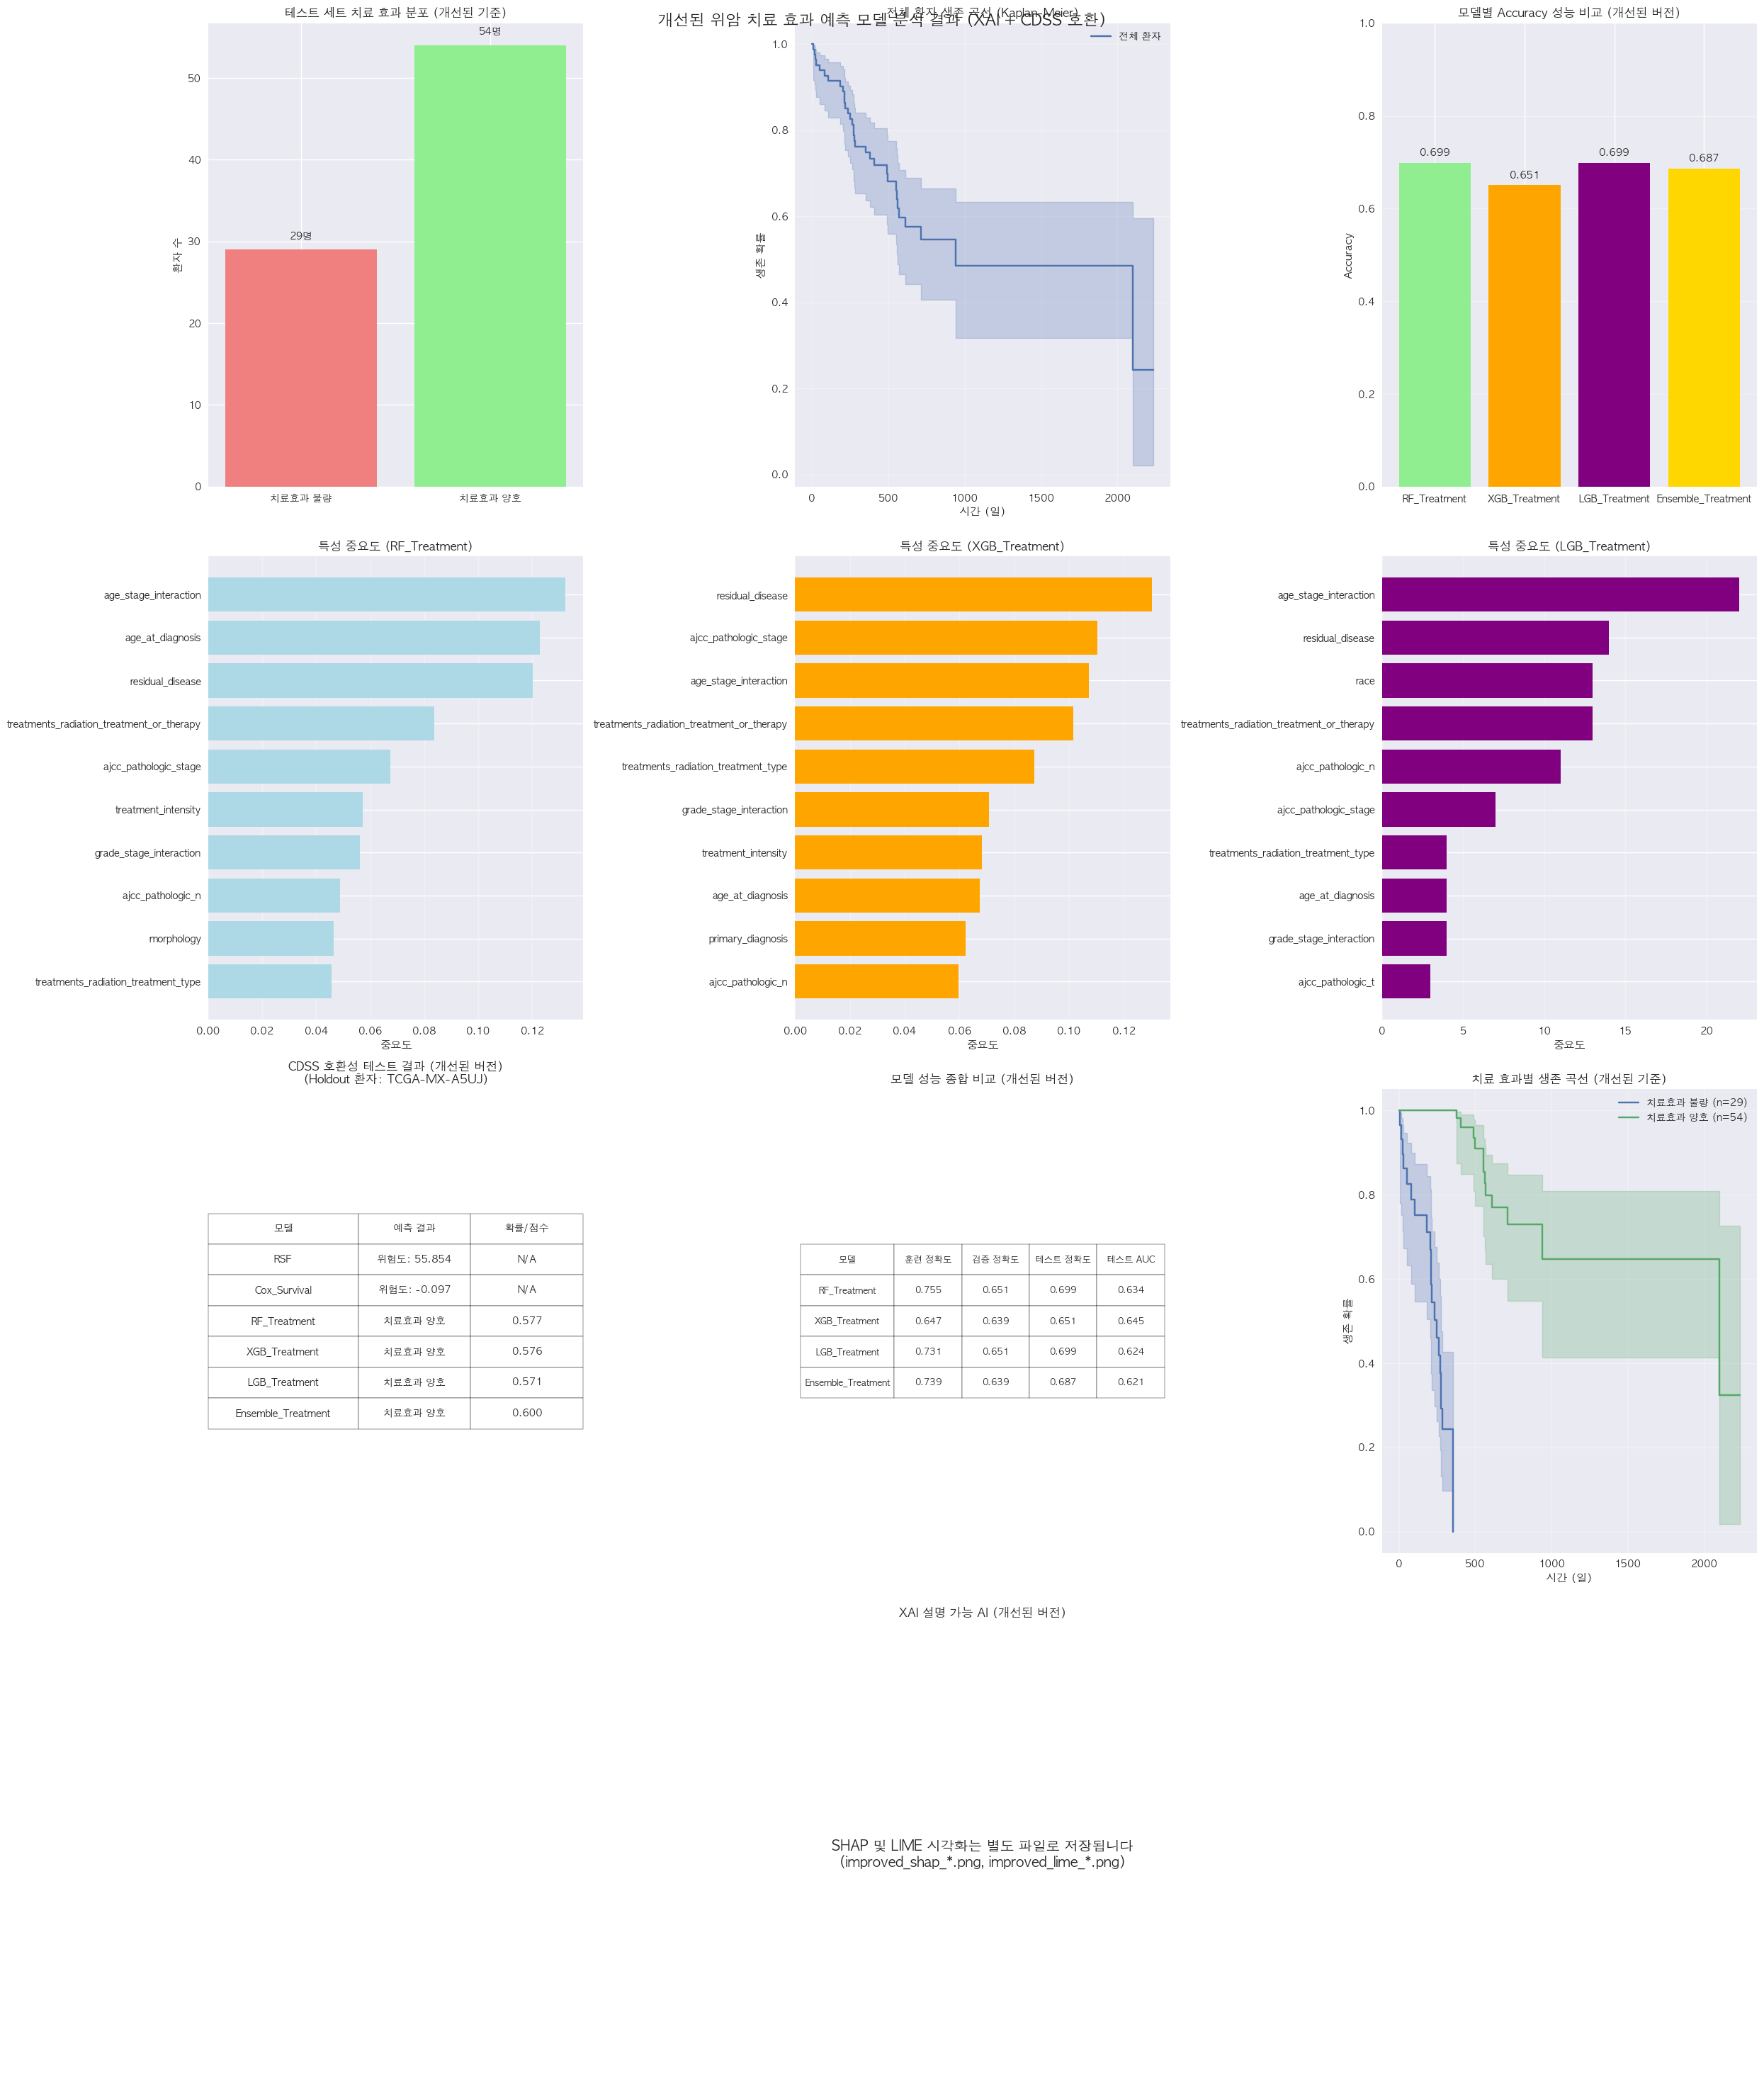


💾 CDSS 호환 모델 저장
✅ RSF 모델 저장: improved_cdss_gastric_cancer_treatment_rsf_model.pkl
✅ Cox_Survival 모델 저장: improved_cdss_gastric_cancer_treatment_cox_survival_model.pkl
✅ RF_Treatment 모델 저장: improved_cdss_gastric_cancer_treatment_rf_treatment_model.pkl
✅ XGB_Treatment 모델 저장: improved_cdss_gastric_cancer_treatment_xgb_treatment_model.pkl
✅ LGB_Treatment 모델 저장: improved_cdss_gastric_cancer_treatment_lgb_treatment_model.pkl
✅ Ensemble_Treatment 모델 저장: improved_cdss_gastric_cancer_treatment_ensemble_treatment_model.pkl
✅ 전체 파이프라인 저장: improved_cdss_gastric_cancer_treatment_complete_pipeline.pkl

📋 최종 보고서 생성 (개선된 버전)

개선된 위암 치료 효과 예측 모델 분석 보고서 (CDSS 호환 + XAI + 성능 최적화)

📊 데이터 개요:
- 총 환자 수: 416명
- 사망 환자: 172명
- 사망률: 41.3%
- 중간 추적 기간: 450일
- 치료 효과 양호: 269명 (64.7%)

🎯 모델 성능 요약 (개선된 버전):

RSF:
  - Train: C-index = 0.830
  - Validation: C-index = 0.619
  - Test: C-index = 0.703

Cox_Survival:
  - Train: C-index = 0.781
  - Validation: C-index = 0.629
  - Test: C-index = 0.743

RF_Treatment:
  - Trai

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os
import shap
from lime import lime_tabular
import pickle

# 생존 분석 라이브러리
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbalancedPipeline
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

def setup_korean_font():
    """한글 폰트 설정"""
    import platform
    import matplotlib.font_manager as fm
    
    system = platform.system()
    
    if system == 'Windows':
        try:
            plt.rcParams['font.family'] = 'Malgun Gothic'
        except:
            try:
                font_path = 'C:/Windows/Fonts/malgun.ttf'
                font_name = fm.FontProperties(fname=font_path).get_name()
                plt.rc('font', family=font_name)
            except:
                print("⚠️ 한글 폰트 설정 실패")
    elif system == 'Darwin':
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'NanumGothic'
    
    plt.rcParams['axes.unicode_minus'] = False
    print("✅ 한글 폰트 설정 완료")

class ImprovedGastricCancerTreatmentEffectPredictorCDSS:
    """개선된 위암 치료 효과 예측 모델 클래스 (CDSS 호환 + XAI + 성능 최적화)"""
    
    def __init__(self, data_path, holdout_submitter_id="TCGA-MX-A5UJ"):
        setup_korean_font()
        self.data_path = data_path
        self.holdout_submitter_id = holdout_submitter_id
        self.df = None
        self.processed_df = None
        self.models = {}
        self.results = {}
        self.feature_names = []
        self.scaler = None
        self.label_encoders = {}
        self.shap_explainers = {}
        self.shap_values = {}
        self.lime_explainers = {}
        self.holdout_patient = None
        
        print(f"🚀 개선된 위암 치료 효과 예측 모델 초기화 (CDSS 호환 + XAI + 성능 최적화)")
        print(f"📁 데이터 경로: {data_path}")
        print(f"🔍 홀드아웃 환자: {holdout_submitter_id}")
        print(f"⏰ 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("="*60)
    
    def load_and_explore_data(self):
        """데이터 로드 및 탐색적 분석"""
        print("\n📊 1. 데이터 로드 및 탐색")
        
        try:
            self.df = pd.read_csv(self.data_path)
            print(f"✅ 데이터 로드 성공: {self.df.shape[0]}행 × {self.df.shape[1]}열")
        except Exception as e:
            print(f"❌ 데이터 로드 실패: {e}")
            return False
        
        # 기본 정보 출력
        print(f"📈 데이터 기본 정보:")
        print(f"   - 총 환자 수: {len(self.df)}")
        print(f"   - 총 컬럼 수: {len(self.df.columns)}")
        
        # 생존 상태 분포
        if 'vital_status' in self.df.columns:
            status_counts = self.df['vital_status'].value_counts()
            print(f"   - 생존 환자: {status_counts.get('Alive', 0)}명")
            print(f"   - 사망 환자: {status_counts.get('Dead', 0)}명")
            print(f"   - 사망률: {status_counts.get('Dead', 0)/len(self.df)*100:.1f}%")
        
        return True
    
    def preprocess_data(self):
        """데이터 전처리 (개선된 버전)"""
        print("\n🔧 2. 데이터 전처리 (개선된 버전)")
        
        # 위암 치료 효과 예측 모델용 선택된 컬럼들
        selected_columns = [
            # 치료 결과 변수 (타겟)
            'treatments_pharmaceutical_treatment_outcome', 'treatments_radiation_treatment_outcome',
            'last_known_disease_status', 'progression_or_recurrence',
            
            # 생존 결과 변수
            'vital_status', 'days_to_death', 'days_to_last_follow_up',
            
            # 병기 관련 (가장 중요한 예측 인자)
            'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
            
            # 종양 특성
            'tumor_grade', 'morphology', 'primary_diagnosis', 'residual_disease', 'classification_of_tumor',
            
            # 환자 기본 정보
            'age_at_diagnosis', 'gender', 'race', 'ethnicity', 'submitter_id',
            
            # 치료 관련 (핵심)
            'treatments_pharmaceutical_treatment_intent_type', 'treatments_pharmaceutical_treatment_type',
            'treatments_pharmaceutical_therapeutic_agents', 'treatments_pharmaceutical_number_of_cycles',
            'treatments_pharmaceutical_treatment_dose', 'treatments_pharmaceutical_regimen_or_line_of_therapy',
            
            # 방사선 치료 관련
            'treatments_radiation_treatment_intent_type', 'treatments_radiation_treatment_type',
            'treatments_radiation_treatment_dose', 'treatments_radiation_number_of_cycles',
            
            # 기타 중요 변수
            'prior_treatment', 'prior_malignancy', 'synchronous_malignancy', 'site_of_resection_or_biopsy',
            
            # 약물 치료 세부 정보
            'treatments_pharmaceutical_treatment_dose_units', 'treatments_pharmaceutical_prescribed_dose_units',
            'treatments_pharmaceutical_number_of_fractions', 'treatments_pharmaceutical_treatment_anatomic_sites',
            'treatments_pharmaceutical_prescribed_dose', 'treatments_pharmaceutical_clinical_trial_indicator',
            'treatments_pharmaceutical_route_of_administration', 'treatments_pharmaceutical_course_number',
            
            # 방사선 치료 세부 정보
            'treatments_radiation_treatment_or_therapy', 'treatments_radiation_therapeutic_agents',
            'treatments_radiation_days_to_treatment_end', 'treatments_radiation_clinical_trial_indicator',
            'treatments_radiation_days_to_treatment_start', 'treatments_radiation_number_of_fractions',
            'treatments_radiation_treatment_anatomic_sites', 'treatments_radiation_prescribed_dose_units',
            'treatments_radiation_prescribed_dose', 'treatments_radiation_route_of_administration',
            'treatments_radiation_course_number',
            
            # 예후 관련 (매우 중요)
            'days_to_recurrence',
            
            # 환자 정보 보완
            'age_at_index', 'days_to_birth', 'year_of_birth', 'year_of_death', 'cause_of_death'
        ]
        
        # 존재하는 컬럼만 선택
        available_columns = [col for col in selected_columns if col in self.df.columns]
        missing_columns = [col for col in selected_columns if col not in self.df.columns]
        
        print(f"✅ 사용 가능한 컬럼: {len(available_columns)}개")
        if missing_columns:
            print(f"⚠️  누락된 컬럼: {missing_columns}")
        
        self.processed_df = self.df[available_columns].copy()
        
        # Series 객체를 단일 값으로 변환하는 함수
        def extract_first_value(x):
            if isinstance(x, pd.Series):
                return x.iloc[0] if len(x) > 0 else np.nan
            else:
                return x
        
        # days_to_last_follow_up 컬럼 내 Series 객체를 단일 값으로 변환
        if 'days_to_last_follow_up' in self.processed_df.columns:
            self.processed_df['days_to_last_follow_up'] = self.processed_df['days_to_last_follow_up'].apply(extract_first_value)
        
        # 생존 시간 및 이벤트 변수 생성
        print("🔄 생존 변수 생성 중...")
        self.processed_df['event'] = (self.processed_df['vital_status'] == 'Dead').astype(int)
        
        # 생존 시간 계산
        def calculate_duration(row):
            death_day = row['days_to_death']
            followup_day = row['days_to_last_follow_up']
            
            # death_day가 Series인지 확인하고 처리
            if isinstance(death_day, pd.Series):
                death_day = death_day.iloc[0] if len(death_day) > 0 else np.nan
            
            # followup_day가 Series인지 확인하고 처리
            if isinstance(followup_day, pd.Series):
                followup_day = followup_day.iloc[0] if len(followup_day) > 0 else np.nan
            
            if pd.notna(death_day):
                return death_day
            elif pd.notna(followup_day):
                return followup_day
            else:
                return np.nan
        
        self.processed_df['duration'] = self.processed_df.apply(calculate_duration, axis=1)
        
        # 🔥 개선된 치료 효과 지표 생성 (임상적으로 검증된 방법)
        print("🔄 개선된 치료 효과 지표 생성 중...")
        self.create_clinical_treatment_response()
        
        # 🔥 임상적으로 의미있는 특성 생성
        print("🔄 임상적 특성 엔지니어링 중...")
        self.create_clinical_features()
        
        # 유효하지 않은 생존 시간 제거
        valid_mask = (pd.notna(self.processed_df['duration'])) & (self.processed_df['duration'] > 0)
        self.processed_df = self.processed_df[valid_mask].copy()
        
        print(f"✅ 유효한 생존 데이터: {len(self.processed_df)}명")
        print(f"   - 사망 이벤트: {self.processed_df['event'].sum()}건")
        print(f"   - 중간 생존 시간: {self.processed_df['duration'].median():.0f}일")
        print(f"   - 치료 효과 양호: {self.processed_df['treatment_effectiveness'].sum()}명 ({self.processed_df['treatment_effectiveness'].mean()*100:.1f}%)")
        
        # 결측값 분석
        print("\n📋 결측값 분석:")
        missing_analysis = self.processed_df.isnull().sum()
        missing_percent = (missing_analysis / len(self.processed_df) * 100).round(1)
        
        for col in missing_analysis[missing_analysis > 0].index:
            print(f"   - {col}: {missing_analysis[col]}개 ({missing_percent[col]}%)")
        
        # 높은 결측률 컬럼 제거 (80% 이상)
        high_missing_cols = missing_percent[missing_percent > 80].index.tolist()
        if high_missing_cols:
            print(f"🗑️  높은 결측률 컬럼 제거: {high_missing_cols}")
            self.processed_df = self.processed_df.drop(columns=high_missing_cols)
        
        return True
    
    def create_clinical_treatment_response(self):
        """임상적으로 검증된 치료 반응 지표 생성 (개선된 버전)"""
        
        # 1. RECIST 기준 기반 치료 반응
        treatment_response = np.zeros(len(self.processed_df))
        
        # 약물 치료 결과 기반 (더 엄격한 기준)
        if 'treatments_pharmaceutical_treatment_outcome' in self.processed_df.columns:
            pharma_outcome = self.processed_df['treatments_pharmaceutical_treatment_outcome'].fillna('Unknown')
            # Complete Response만 양호한 반응으로 분류
            complete_response = pharma_outcome.str.contains('Complete Response|CR', case=False, na=False)
            partial_response = pharma_outcome.str.contains('Partial Response|PR', case=False, na=False)
            stable_disease = pharma_outcome.str.contains('Stable Disease|SD', case=False, na=False)
            
            treatment_response += complete_response.astype(int) * 3  # 가중치 증가
            treatment_response += partial_response.astype(int) * 2
            treatment_response += stable_disease.astype(int) * 1
        
        # 2. 무진행 생존기간 기준 (6개월 이상)
        if 'days_to_recurrence' in self.processed_df.columns:
            progression_free_6m = (self.processed_df['days_to_recurrence'] >= 180) | pd.isna(self.processed_df['days_to_recurrence'])
            progression_free_1y = (self.processed_df['days_to_recurrence'] >= 365) | pd.isna(self.processed_df['days_to_recurrence'])
            
            treatment_response += progression_free_6m.astype(int) * 1
            treatment_response += progression_free_1y.astype(int) * 1
        
        # 3. 전체 생존기간 기준 (1년 이상)
        if 'duration' in self.processed_df.columns:
            long_survival_1y = (self.processed_df['duration'] >= 365)
            long_survival_2y = (self.processed_df['duration'] >= 730)
            
            treatment_response += long_survival_1y.astype(int) * 1
            treatment_response += long_survival_2y.astype(int) * 1
        
        # 4. 마지막 질병 상태 기반
        if 'last_known_disease_status' in self.processed_df.columns:
            disease_status = self.processed_df['last_known_disease_status'].fillna('Unknown')
            # 긍정적 상태
            complete_remission = disease_status.str.contains('Complete Remission|No Evidence of Disease', case=False, na=False)
            partial_remission = disease_status.str.contains('Partial Remission', case=False, na=False)
            stable_disease_status = disease_status.str.contains('Stable Disease', case=False, na=False)
            
            treatment_response += complete_remission.astype(int) * 2
            treatment_response += partial_remission.astype(int) * 1
            treatment_response += stable_disease_status.astype(int) * 1
        
        # 더 엄격한 기준: 4점 이상만 치료 효과 양호 (상위 30-40%만 양호로 분류)
        threshold = np.percentile(treatment_response, 60)  # 상위 40%
        self.processed_df['treatment_effectiveness'] = (treatment_response >= threshold).astype(int)
        
        print(f"   - 치료 반응 점수 분포: 최소 {treatment_response.min()}, 최대 {treatment_response.max()}, 평균 {treatment_response.mean():.2f}")
        print(f"   - 치료 효과 임계값: {threshold:.2f}")
    
    def create_clinical_features(self):
        """임상적으로 의미있는 특성 생성"""
        
        # 1. 종합 위험도 점수 (AJCC 기반)
        self.processed_df['comprehensive_risk_score'] = 0
        
        # AJCC 병기 점수화
        if 'ajcc_pathologic_stage' in self.processed_df.columns:
            stage_mapping = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
            for stage, score in stage_mapping.items():
                mask = self.processed_df['ajcc_pathologic_stage'].astype(str).str.contains(stage, na=False)
                self.processed_df.loc[mask, 'comprehensive_risk_score'] += score
        
        # T, N, M 병기 추가
        tnm_cols = ['ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m']
        for col in tnm_cols:
            if col in self.processed_df.columns:
                # 숫자 추출하여 점수화
                tnm_values = self.processed_df[col].astype(str).str.extract('(\d+)', expand=False)
                tnm_numeric = pd.to_numeric(tnm_values, errors='coerce').fillna(0)
                self.processed_df['comprehensive_risk_score'] += tnm_numeric
        
        # 2. 치료 강도 점수
        self.processed_df['treatment_intensity'] = 0
        
        # 화학요법 사이클 수 기반
        if 'treatments_pharmaceutical_number_of_cycles' in self.processed_df.columns:
            cycles = pd.to_numeric(self.processed_df['treatments_pharmaceutical_number_of_cycles'], errors='coerce').fillna(0)
            self.processed_df['treatment_intensity'] += np.where(cycles >= 6, 3, 
                                                               np.where(cycles >= 4, 2, 
                                                                      np.where(cycles >= 1, 1, 0)))
        
        # 방사선 치료 여부
        if 'treatments_radiation_treatment_type' in self.processed_df.columns:
            has_radiation = self.processed_df['treatments_radiation_treatment_type'].notna()
            self.processed_df['treatment_intensity'] += has_radiation.astype(int) * 2
        
        # 다중 치료 여부
        pharma_treatment = self.processed_df.get('treatments_pharmaceutical_treatment_type', pd.Series()).notna()
        radiation_treatment = self.processed_df.get('treatments_radiation_treatment_type', pd.Series()).notna()
        multimodal_treatment = pharma_treatment & radiation_treatment
        self.processed_df['treatment_intensity'] += multimodal_treatment.astype(int)
        
        # 3. 나이-병기 상호작용
        if 'age_at_diagnosis' in self.processed_df.columns:
            age_normalized = (self.processed_df['age_at_diagnosis'] - 65) / 10  # 65세 기준 정규화
            self.processed_df['age_stage_interaction'] = age_normalized * self.processed_df['comprehensive_risk_score']
        
        # 4. 종양 등급-병기 상호작용
        if 'tumor_grade' in self.processed_df.columns:
            grade_numeric = self.processed_df['tumor_grade'].astype(str).str.extract('(\d+)', expand=False)
            grade_numeric = pd.to_numeric(grade_numeric, errors='coerce').fillna(2)  # 기본값 G2
            self.processed_df['grade_stage_interaction'] = grade_numeric * self.processed_df['comprehensive_risk_score']
        
        # 5. 치료 반응 예측 점수 (복합 지표)
        self.processed_df['treatment_response_prediction'] = (
            self.processed_df['treatment_intensity'] * 0.4 +
            (5 - self.processed_df['comprehensive_risk_score']) * 0.3 +  # 위험도가 낮을수록 좋은 반응
            -self.processed_df.get('age_stage_interaction', 0) * 0.2 +  # 나이-병기 상호작용 (음의 영향)
            self.processed_df.get('grade_stage_interaction', 0) * -0.1  # 등급-병기 상호작용 (음의 영향)
        )
        
        print(f"   - 종합 위험도 점수 범위: {self.processed_df['comprehensive_risk_score'].min():.1f} ~ {self.processed_df['comprehensive_risk_score'].max():.1f}")
        print(f"   - 치료 강도 점수 범위: {self.processed_df['treatment_intensity'].min():.1f} ~ {self.processed_df['treatment_intensity'].max():.1f}")
    
    def prepare_features(self):
        """특성 준비 및 인코딩 (CDSS 호환)"""
        print("\n🎯 3. 특성 준비 및 인코딩")
        
        # 🔥 특정 환자 홀드아웃 (TCGA-MX-A5UJ)
        print(f"🔄 특정 환자 홀드아웃 중: {self.holdout_submitter_id}")
        
        if 'submitter_id' in self.processed_df.columns:
            holdout_mask = self.processed_df['submitter_id'] == self.holdout_submitter_id
            
            if holdout_mask.any():
                self.holdout_patient = self.processed_df[holdout_mask].copy()
                remaining_df = self.processed_df[~holdout_mask].copy()
                print(f"✅ 홀드아웃 환자 발견: {self.holdout_submitter_id}")
                print(f"   - 홀드아웃 환자: 1명")
                print(f"   - 모델 훈련용 데이터: {len(remaining_df)}명")
            else:
                print(f"⚠️ 홀드아웃 환자 {self.holdout_submitter_id}를 찾을 수 없습니다.")
                print("🔄 랜덤 홀드아웃으로 대체...")
                holdout_idx = self.processed_df.sample(n=1, random_state=42).index[0]
                self.holdout_patient = self.processed_df.loc[holdout_idx:holdout_idx].copy()
                remaining_df = self.processed_df.drop(holdout_idx).copy()
                print(f"   - 랜덤 홀드아웃 환자: {holdout_idx}")
                print(f"   - 모델 훈련용 데이터: {len(remaining_df)}명")
        else:
            print("⚠️ submitter_id 컬럼이 없습니다. 랜덤 홀드아웃으로 진행...")
            holdout_idx = self.processed_df.sample(n=1, random_state=42).index[0]
            self.holdout_patient = self.processed_df.loc[holdout_idx:holdout_idx].copy()
            remaining_df = self.processed_df.drop(holdout_idx).copy()
        
        # 특성과 타겟 분리
        feature_cols = [col for col in remaining_df.columns 
                       if col not in ['vital_status', 'days_to_death', 'days_to_last_follow_up', 
                                     'event', 'duration', 'treatment_effectiveness', 'submitter_id',
                                     'treatments_pharmaceutical_treatment_outcome', 'treatments_radiation_treatment_outcome',
                                     'last_known_disease_status', 'progression_or_recurrence']]
        
        X = remaining_df[feature_cols].copy()
        y_duration = remaining_df['duration'].values
        y_event = remaining_df['event'].values.astype(bool)
        y_effectiveness = remaining_df['treatment_effectiveness'].values
        
        print(f"📊 초기 특성 개수: {len(feature_cols)}")
        print(f"📊 샘플 개수: {len(X)}")
        print(f"📊 치료효과 분포: 불량 {(y_effectiveness==0).sum()}명, 양호 {(y_effectiveness==1).sum()}명")
        
        # 범주형 변수 인코딩
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        print(f"🔤 범주형 변수: {len(categorical_cols)}개")
        print(f"🔢 수치형 변수: {len(numerical_cols)}개")
        
        # 결측값 처리
        print("🔄 결측값 처리 중...")
        
        # 임상적으로 의미있는 Unknown 값을 가질 수 있는 컬럼들 (위암 특화)
        meaningful_unknown_cols = [
            'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
            'tumor_grade', 'morphology', 'primary_diagnosis', 'residual_disease', 'classification_of_tumor',
            'treatments_pharmaceutical_treatment_intent_type', 'treatments_pharmaceutical_treatment_type',
            'treatments_pharmaceutical_therapeutic_agents', 'treatments_pharmaceutical_regimen_or_line_of_therapy',
            'treatments_radiation_treatment_intent_type', 'treatments_radiation_treatment_type',
            'prior_treatment', 'prior_malignancy', 'synchronous_malignancy'
        ]
        
        self.label_encoders = {}
        
        for col in categorical_cols:
            if col in X.columns:
                print(f"\n   🔍 {col} 처리:")
                
                # 현재 값 분포 확인
                value_counts = X[col].value_counts(dropna=False)
                print(f"      - 전처리 전 분포: {dict(list(value_counts.items())[:3])}")
                
                # 'NA' 문자열을 결측치로 변환
                if 'NA' in X[col].values:
                    X[col] = X[col].replace('NA', np.nan)
                    print(f"      - 'NA' 문자열을 결측치로 변환")
                
                # Unknown 값 처리 결정
                try:
                    # 문자열로 변환 후 contains 호출
                    has_unknown = X[col].astype(str).str.contains('Unknown', na=False).any()
                except Exception as e:
                    print(f"      - .str.contains 오류 발생, False로 설정: {e}")
                    has_unknown = False
                
                if has_unknown:
                    if col in meaningful_unknown_cols:
                        print(f"      - 'Unknown' 값 유지 (임상적 의미 있음)")
                        if X[col].isnull().any():
                            mode_value = X[col].mode()
                            if not mode_value.empty:
                                fill_value = mode_value[0]
                                X[col] = X[col].fillna(fill_value)
                                print(f"      - 결측치를 '{fill_value}'로 대체")
                    else:
                        print(f"      - 'Unknown' 값을 결측치로 변환 후 대체")
                        X[col] = X[col].replace('Unknown', np.nan)
                        if X[col].isnull().any():
                            mode_value = X[col].mode()
                            if not mode_value.empty:
                                fill_value = mode_value[0]
                                X[col] = X[col].fillna(fill_value)
                                print(f"      - 결측치를 '{fill_value}'로 대체")
                else:
                    if X[col].isnull().any():
                        mode_value = X[col].mode()
                        if not mode_value.empty:
                            fill_value = mode_value[0]
                            X[col] = X[col].fillna(fill_value)
                            print(f"      - 결측치를 '{fill_value}'로 대체")
        
        # 모든 범주형 변수 인코딩
        print("\n🔄 범주형 변수 인코딩:")
        all_categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        for col in all_categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le
            
            if col in meaningful_unknown_cols:
                mapping = dict(zip(le.classes_, le.transform(le.classes_)))
                print(f"   - {col} 인코딩 매핑: {mapping}")
        
        # 모든 특성을 수치형으로 변환
        for col in X.columns:
            X[col] = pd.to_numeric(X[col], errors='coerce')
        
        # 전체 특성에 대해 Imputer 훈련
        print(f"\n📏 전체 특성 Imputer 훈련:")
        print(f"   - 전체 특성 수: {X.shape[1]}")
        
        self.num_imputer = SimpleImputer(strategy='median')
        X_imputed = self.num_imputer.fit_transform(X)
        X = pd.DataFrame(X_imputed, columns=X.columns, index=X.index)
        
        print(f"✅ 전체 특성 Imputer 훈련 완료: {X.shape[1]}개 특성")
        
        # 다중공선성 해결 (완화된 기준)
        print("\n🔍 다중공선성 검사 및 해결 (완화된 기준):")
        
        # 1. 분산이 0인 특성 제거
        zero_var_features = [col for col in X.columns if X[col].nunique() <= 1]
        if zero_var_features:
            print(f"🗑️  분산 0인 특성 제거: {zero_var_features}")
            X = X.drop(columns=zero_var_features)
        
        # 2. 높은 상관관계 특성 제거 (완화된 기준: 0.95)
        corr_matrix = X.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]
        
        if high_corr_features:
            print(f"🗑️  높은 상관관계 특성 제거 (>0.95): {high_corr_features}")
            X = X.drop(columns=high_corr_features)
        
        print(f"📊 최종 특성 개수: {len(X.columns)}")
        
        # 특성 스케일링
        self.scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            self.scaler.fit_transform(X),
            columns=X.columns,
            index=X.index
        )
        
        self.feature_names = X_scaled.columns.tolist()
        
        # scikit-survival 형식으로 변환
        y_structured = np.array([(event, duration) for event, duration in zip(y_event, y_duration)],
                               dtype=[('event', '?'), ('time', '<f8')])
        
        print("✅ 특성 준비 완료 (CDSS 호환)")
        
        return X_scaled, y_structured, y_duration, y_event, y_effectiveness
    
    def balance_treatment_data(self, X_train, y_train_eff):
        """치료효과 데이터 균형 조정 (개선된 버전)"""
        print("\n⚖️ 데이터 균형 조정:")
        print(f"   - 원본 분포: 불량 {(y_train_eff==0).sum()}명, 양호 {(y_train_eff==1).sum()}명")
        
        # 1단계: SMOTE로 소수 클래스 증강
        smote = SMOTE(random_state=42, k_neighbors=min(3, (y_train_eff==1).sum()-1))
        
        # 2단계: 언더샘플링으로 다수 클래스 감소
        under_sampler = RandomUnderSampler(random_state=42, sampling_strategy=0.8)
        
        # 파이프라인 적용
        try:
            pipeline = ImbalancedPipeline([
                ('smote', smote),
                ('under', under_sampler)
            ])
            
            X_balanced, y_balanced = pipeline.fit_resample(X_train, y_train_eff)
            
            print(f"   - 균형 조정 후: 불량 {(y_balanced==0).sum()}명, 양호 {(y_balanced==1).sum()}명")
            print(f"   - 샘플 수 변화: {len(X_train)} → {len(X_balanced)}")
            
            return X_balanced, y_balanced
            
        except Exception as e:
            print(f"   ⚠️ 데이터 균형 조정 실패: {e}")
            print(f"   - 원본 데이터 사용")
            return X_train, y_train_eff
    
    def split_data(self, X, y_structured, y_duration, y_event, y_effectiveness):
        """데이터 분할"""
        print("\n✂️  4. 데이터 분할 (훈련:검증:테스트 = 60:20:20)")
        
        # 먼저 훈련+검증 vs 테스트로 분할
        X_temp, X_test, y_temp_struct, y_test_struct, y_temp_dur, y_test_dur, y_temp_event, y_test_event, y_temp_eff, y_test_eff = \
            train_test_split(X, y_structured, y_duration, y_event, y_effectiveness,
                           test_size=0.2, random_state=42, stratify=y_effectiveness)
        
        # 훈련 vs 검증으로 분할
        X_train, X_val, y_train_struct, y_val_struct, y_train_dur, y_val_dur, y_train_event, y_val_event, y_train_eff, y_val_eff = \
            train_test_split(X_temp, y_temp_struct, y_temp_dur, y_temp_event, y_temp_eff,
                           test_size=0.25, random_state=42, stratify=y_temp_eff)
        
        print(f"📊 훈련 세트: {len(X_train)}명 (사망: {y_train_event.sum()}명, 치료효과양호: {y_train_eff.sum()}명)")
        print(f"📊 검증 세트: {len(X_val)}명 (사망: {y_val_event.sum()}명, 치료효과양호: {y_val_eff.sum()}명)")
        print(f"📊 테스트 세트: {len(X_test)}명 (사망: {y_test_event.sum()}명, 치료효과양호: {y_test_eff.sum()}명)")
        print(f"📊 CDSS 테스트: 1명 (별도 보관)")
        
        return (X_train, X_val, X_test, 
                y_train_struct, y_val_struct, y_test_struct,
                y_train_dur, y_val_dur, y_test_dur,
                y_train_event, y_val_event, y_test_event,
                y_train_eff, y_val_eff, y_test_eff)
    
    def create_ensemble_model(self):
        """앙상블 모델로 성능 향상"""
        
        # 개별 모델들 (과적합 방지 설정)
        rf_model = RandomForestClassifier(
            n_estimators=50, max_depth=5, min_samples_split=20,
            min_samples_leaf=10, max_features='sqrt', random_state=42
        )
        
        lgb_model = lgb.LGBMClassifier(
            n_estimators=50, max_depth=3, learning_rate=0.05,
            num_leaves=10, min_child_samples=20, random_state=42, verbose=-1
        )
        
        lr_model = LogisticRegression(
            C=0.1, random_state=42, max_iter=1000
        )
        
        # 소프트 보팅 앙상블
        ensemble_model = VotingClassifier(
            estimators=[
                ('rf', rf_model),
                ('lgb', lgb_model),
                ('lr', lr_model)
            ],
            voting='soft'
        )
        
        return ensemble_model
    
    def train_models(self, X_train, X_val, X_test, 
                    y_train_struct, y_val_struct, y_test_struct,
                    y_train_dur, y_val_dur, y_test_dur,
                    y_train_event, y_val_event, y_test_event,
                    y_train_eff, y_val_eff, y_test_eff):
        """모델 훈련 (성능 최적화 버전)"""
        print("\n🤖 5. 모델 훈련 (성능 최적화 버전)")
        
        # 🔥 데이터 균형 조정
        X_train_balanced, y_train_eff_balanced = self.balance_treatment_data(X_train, y_train_eff)
        
        # 1. Random Survival Forest (생존 예측)
        print("🔄 Random Survival Forest 훈련 중...")
        try:
            rsf_model = RandomSurvivalForest(
                n_estimators=100,
                max_depth=8,
                min_samples_split=15,
                min_samples_leaf=8,
                random_state=42,
                n_jobs=-1
            )
            rsf_model.fit(X_train, y_train_struct)
            
            rsf_wrapper = {
                'model': rsf_model,
                'model_type': 'RandomSurvivalForest',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'training_info': {
                    'n_samples': len(X_train),
                    'n_features': len(self.feature_names),
                    'event_rate': y_train_event.mean()
                }
            }
            
            self.models['RSF'] = rsf_wrapper
            print("✅ Random Survival Forest 훈련 완료")
        except Exception as e:
            print(f"❌ RSF 모델 훈련 실패: {e}")
        
        # 2. Cox 비례위험 모델 (생존 예측)
        print("🔄 Cox 비례위험 모델 훈련 중...")
        try:
            cox_model = CoxPHSurvivalAnalysis(alpha=0.5)
            cox_model.fit(X_train, y_train_struct)
            
            cox_wrapper = {
                'model': cox_model,
                'model_type': 'CoxPHSurvivalAnalysis',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'training_info': {
                    'n_samples': len(X_train),
                    'n_features': len(self.feature_names),
                    'event_rate': y_train_event.mean()
                }
            }
            
            self.models['Cox_Survival'] = cox_wrapper
            print("✅ Cox 생존 모델 훈련 완료")
        except Exception as e:
            print(f"❌ Cox 모델 훈련 실패: {e}")
        
        # 3. Random Forest (개선된 설정)
        print("🔄 Random Forest 개선된 설정으로 훈련 중...")
        try:
            rf_classifier = RandomForestClassifier(
                n_estimators=100,
                max_depth=6,           # 🔥 8 → 6 감소
                min_samples_split=20,  # 🔥 15 → 20 증가
                min_samples_leaf=10,   # 🔥 8 → 10 증가
                max_features='sqrt',
                random_state=42,
                n_jobs=-1
            )
            rf_classifier.fit(X_train_balanced, y_train_eff_balanced)
            
            rf_wrapper = {
                'model': rf_classifier,
                'model_type': 'RandomForestClassifier',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'class_labels': ['치료효과 불량', '치료효과 양호'],
                'training_info': {
                    'n_samples': len(X_train_balanced),
                    'n_features': len(self.feature_names),
                    'class_distribution': np.bincount(y_train_eff_balanced),
                    'feature_importance': rf_classifier.feature_importances_
                }
            }
            
            self.models['RF_Treatment'] = rf_wrapper
            print("✅ Random Forest 개선된 훈련 완료")
        except Exception as e:
            print(f"❌ RF 모델 훈련 실패: {e}")
        
        # 4. XGBoost (강화된 과적합 방지)
        print("🔄 XGBoost 강화된 과적합 방지로 훈련 중...")
        try:
            xgb_model = xgb.XGBClassifier(
                n_estimators=50,
                max_depth=3,
                learning_rate=0.05,
                subsample=0.7,
                colsample_bytree=0.7,
                reg_alpha=2.0,
                reg_lambda=2.0,
                min_child_weight=5,
                gamma=1.0,
                random_state=42,
                eval_metric='logloss',
                early_stopping_rounds=5  # 🔥 여기로 이동
            )
            
            # 🔥 수정: fit 메서드에서 early_stopping_rounds 제거
            xgb_model.fit(
                X_train_balanced, y_train_eff_balanced,
                eval_set=[(X_val, y_val_eff)],
                verbose=False
            )
            
            xgb_wrapper = {
                'model': xgb_model,
                'model_type': 'XGBClassifier',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'class_labels': ['치료효과 불량', '치료효과 양호'],
                'training_info': {
                    'n_samples': len(X_train_balanced),
                    'n_features': len(self.feature_names),
                    'class_distribution': np.bincount(y_train_eff_balanced),
                    'feature_importance': xgb_model.feature_importances_
                }
            }
            
            self.models['XGB_Treatment'] = xgb_wrapper
            print("✅ XGBoost 강화된 과적합 방지 훈련 완료")
        except Exception as e:
            print(f"❌ XGBoost 모델 훈련 실패: {e}")
        
        # 5. LightGBM (최적화된 설정)
        print("🔄 LightGBM 최적화된 설정으로 훈련 중...")
        try:
            lgb_model = lgb.LGBMClassifier(
                n_estimators=100,
                max_depth=4,
                learning_rate=0.05,
                num_leaves=15,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.5,
                reg_lambda=0.5,
                min_child_samples=20,
                min_child_weight=0.001,
                random_state=42,
                verbose=-1
            )
            
            lgb_model.fit(
                X_train_balanced, y_train_eff_balanced,
                eval_set=[(X_val, y_val_eff)],
                callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
            )
            
            lgb_wrapper = {
                'model': lgb_model,
                'model_type': 'LGBMClassifier',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'class_labels': ['치료효과 불량', '치료효과 양호'],
                'training_info': {
                    'n_samples': len(X_train_balanced),
                    'n_features': len(self.feature_names),
                    'class_distribution': np.bincount(y_train_eff_balanced),
                    'feature_importance': lgb_model.feature_importances_
                }
            }
            
            self.models['LGB_Treatment'] = lgb_wrapper
            print("✅ LightGBM 최적화된 훈련 완료")
        except Exception as e:
            print(f"❌ LightGBM 모델 훈련 실패: {e}")
        
        # 6. 앙상블 모델 (새로 추가)
        print("🔄 앙상블 모델 훈련 중...")
        try:
            ensemble_model = self.create_ensemble_model()
            ensemble_model.fit(X_train_balanced, y_train_eff_balanced)
            
            ensemble_wrapper = {
                'model': ensemble_model,
                'model_type': 'VotingClassifier',
                'feature_names': self.feature_names,
                'scaler': self.scaler,
                'label_encoders': self.label_encoders,
                'num_imputer': self.num_imputer,
                'class_labels': ['치료효과 불량', '치료효과 양호'],
                'training_info': {
                    'n_samples': len(X_train_balanced),
                    'n_features': len(self.feature_names),
                    'class_distribution': np.bincount(y_train_eff_balanced)
                }
            }
            
            self.models['Ensemble_Treatment'] = ensemble_wrapper
            print("✅ 앙상블 모델 훈련 완료")
        except Exception as e:
            print(f"❌ 앙상블 모델 훈련 실패: {e}")
        
        print(f"\n🎯 성능 최적화된 {len(self.models)}개 모델 훈련 완료")
        
        return True
    
    def evaluate_models(self, X_train, X_val, X_test,
                       y_train_struct, y_val_struct, y_test_struct,
                       y_train_dur, y_val_dur, y_test_dur,
                       y_train_event, y_val_event, y_test_event,
                       y_train_eff, y_val_eff, y_test_eff):
        """모델 평가"""
        print("\n📈 6. 모델 평가")
        
        datasets = {
            'Train': (X_train, y_train_struct, y_train_dur, y_train_event, y_train_eff),
            'Validation': (X_val, y_val_struct, y_val_dur, y_val_event, y_val_eff),
            'Test': (X_test, y_test_struct, y_test_dur, y_test_event, y_test_eff)
        }
        
        for model_name, model_wrapper in self.models.items():
            print(f"\n🔍 {model_name} 모델 평가:")
            self.results[model_name] = {}
            
            for dataset_name, (X, y_struct, y_dur, y_event, y_eff) in datasets.items():
                try:
                    actual_model = model_wrapper['model']
                    model_type = model_wrapper['model_type']
                    
                    if model_type in ['RandomSurvivalForest', 'CoxPHSurvivalAnalysis']:
                        # 생존 모델 평가
                        risk_scores = actual_model.predict(X)
                        c_index = concordance_index_censored(y_struct['event'], y_struct['time'], risk_scores)[0]
                        self.results[model_name][dataset_name] = {'c_index': c_index}
                        print(f"   {dataset_name}: C-index = {c_index:.3f}")
                    
                    else:
                        # 분류 모델 평가 (치료 효과)
                        y_pred = actual_model.predict(X)
                        accuracy = (y_pred == y_eff).mean()
                        
                        try:
                            y_proba = actual_model.predict_proba(X)
                            auc_score = roc_auc_score(y_eff, y_proba[:, 1])
                        except:
                            auc_score = np.nan
                        
                        self.results[model_name][dataset_name] = {
                            'accuracy': accuracy,
                            'auc': auc_score
                        }
                        print(f"   {dataset_name}: Accuracy = {accuracy:.3f}, AUC = {auc_score:.3f}")
                    
                except Exception as e:
                    print(f"   ❌ {dataset_name} 평가 실패: {e}")
                    self.results[model_name][dataset_name] = {'error': str(e)}
        
        return True
    
    def explain_models(self, X_train, X_test):
        """XAI 모델 설명 생성"""
        print("\n🔍 XAI 모델 설명 생성")
        
        # SHAP 설명기 초기화
        print("🔄 SHAP 설명 생성 중...")
        tree_models = ['RF_Treatment', 'XGB_Treatment', 'LGB_Treatment']
        
        for model_name in tree_models:
            if model_name in self.models:
                try:
                    X_test_sample = X_test.iloc[:50]
                    
                    actual_model = self.models[model_name]['model']
                    
                    explainer = shap.TreeExplainer(actual_model)
                    shap_values = explainer.shap_values(X_test_sample)
                    
                    self.shap_explainers[model_name] = explainer
                    self.shap_values[model_name] = shap_values
                    print(f"✅ {model_name} SHAP 설명 생성 완료")
                except Exception as e:
                    print(f"❌ {model_name} SHAP 실패: {e}")
        
        # LIME 설명기 초기화
        print("\n🔄 LIME 설명 생성 중...")
        classification_models = ['RF_Treatment', 'XGB_Treatment', 'LGB_Treatment', 'Ensemble_Treatment']
        
        for model_name in classification_models:
            if model_name in self.models:
                try:
                    actual_model = self.models[model_name]['model']
                    class_labels = self.models[model_name]['class_labels']
                    
                    explainer = lime_tabular.LimeTabularExplainer(
                        training_data=X_train.values,
                        feature_names=self.feature_names,
                        class_names=class_labels,
                        mode='classification',
                        discretize_continuous=True
                    )
                    
                    self.lime_explainers[model_name] = {
                        'explainer': explainer,
                        'predict_fn': actual_model.predict_proba
                    }
                    print(f"✅ {model_name} LIME 설명기 생성 완료")
                except Exception as e:
                    print(f"❌ {model_name} LIME 실패: {e}")
        
        return True
    
    def generate_xai_visualizations(self, X_test, sample_index=0):
        """XAI 시각화 생성 및 저장 (개선된 버전)"""
        print("\n📊 XAI 시각화 생성 (개선된 버전)")
        
        # SHAP 시각화
        shap_figures = []
        for model_name in self.shap_explainers:
            try:
                print(f"🔄 {model_name} SHAP 시각화 생성 중...")
                
                shap_vals = self.shap_values[model_name]
                
                # 이진 분류 SHAP 값 처리 (개선된 버전)
                if isinstance(shap_vals, list) and len(shap_vals) == 2:
                    # 클래스 1 (치료효과 양호)에 대한 SHAP 값 사용
                    shap_vals_to_plot = shap_vals[1]
                    expected_val = self.shap_explainers[model_name].expected_value[1]
                    print(f"   - 리스트 형태 SHAP 값 감지: 클래스 1 사용")
                elif hasattr(shap_vals, 'shape') and shap_vals.ndim == 3:
                    # 3차원 배열: (샘플, 특성, 클래스)
                    shap_vals_to_plot = shap_vals[:, :, 1]  # 클래스 1
                    expected_val = (self.shap_explainers[model_name].expected_value[1] 
                                if hasattr(self.shap_explainers[model_name].expected_value, '__len__') 
                                else self.shap_explainers[model_name].expected_value)
                    print(f"   - 3차원 배열 SHAP 값 감지: 클래스 1 추출")
                else:
                    # 2차원 배열 또는 기타
                    shap_vals_to_plot = shap_vals
                    expected_val = (self.shap_explainers[model_name].expected_value 
                                if not hasattr(self.shap_explainers[model_name].expected_value, '__len__')
                                else self.shap_explainers[model_name].expected_value[0])
                    print(f"   - 2차원 배열 SHAP 값 사용")
                
                print(f"   - SHAP 값 형태: {shap_vals_to_plot.shape}")
                print(f"   - 기댓값: {expected_val}")
                
                # Summary plot (전역 설명)
                plt.figure(figsize=(12, 8))
                try:
                    shap.summary_plot(shap_vals_to_plot, X_test.iloc[:50], 
                                    feature_names=self.feature_names,
                                    plot_type="bar", show=False)
                    plt.title(f"{model_name} 특성 중요도 (SHAP)", fontsize=14, fontweight='bold')
                    plt.xlabel('평균 |SHAP 값|', fontsize=12)
                    plt.tight_layout()
                    shap_summary_path = f"improved_shap_summary_{model_name}_gastric_treatment.png"
                    plt.savefig(shap_summary_path, dpi=300, bbox_inches='tight')
                    plt.close()
                    print(f"   ✅ Summary plot 저장: {shap_summary_path}")
                except Exception as summary_error:
                    print(f"   ❌ Summary plot 실패: {summary_error}")
                    plt.close()
                    continue
                
                # Individual explanation (개별 설명)
                try:
                    plt.figure(figsize=(14, 8))
                    
                    # 개별 샘플의 SHAP 값 추출
                    if shap_vals_to_plot.ndim == 2:
                        individual_shap = shap_vals_to_plot[sample_index, :]
                    else:
                        individual_shap = shap_vals_to_plot[sample_index] if sample_index < len(shap_vals_to_plot) else shap_vals_to_plot[0]
                    
                    # 기댓값 처리
                    if hasattr(expected_val, '__len__') and len(expected_val) > 0:
                        base_value = float(expected_val[0]) if hasattr(expected_val[0], '__float__') else 0.0
                    else:
                        base_value = float(expected_val) if hasattr(expected_val, '__float__') else 0.0
                    
                    print(f"   - 개별 SHAP 값 형태: {individual_shap.shape}")
                    print(f"   - 기댓값 (base_value): {base_value}")
                    
                    # Waterfall plot 시도
                    try:
                        shap.waterfall_plot(
                            shap.Explanation(
                                values=individual_shap.astype(float),
                                base_values=base_value,
                                data=X_test.iloc[sample_index].values.astype(float),
                                feature_names=self.feature_names
                            ),
                            show=False
                        )
                        plt.title(f"{model_name} 개별 설명 - Waterfall Plot\n(환자 {sample_index}: 치료효과 예측)", 
                                 fontsize=14, fontweight='bold')
                        plt.tight_layout()
                        shap_waterfall_path = f"improved_shap_waterfall_{model_name}_gastric_treatment_{sample_index}.png"
                        plt.savefig(shap_waterfall_path, dpi=300, bbox_inches='tight')
                        plt.close()
                        
                        shap_figures.extend([shap_summary_path, shap_waterfall_path])
                        print(f"   ✅ Waterfall plot 저장: {shap_waterfall_path}")
                        
                    except Exception as waterfall_error:
                        print(f"   ⚠️ Waterfall plot 실패, Force plot으로 대체: {waterfall_error}")
                        plt.close()
                        
                        # Force plot으로 대체
                        try:
                            plt.figure(figsize=(14, 6))
                            shap.force_plot(
                                base_value,
                                individual_shap,
                                X_test.iloc[sample_index],
                                feature_names=self.feature_names,
                                matplotlib=True,
                                show=False
                            )
                            plt.title(f"{model_name} 개별 설명 - Force Plot\n(환자 {sample_index}: 치료효과 예측)", 
                                     fontsize=14, fontweight='bold')
                            plt.tight_layout()
                            shap_force_path = f"improved_shap_force_{model_name}_gastric_treatment_{sample_index}.png"
                            plt.savefig(shap_force_path, dpi=300, bbox_inches='tight')
                            plt.close()
                            
                            shap_figures.extend([shap_summary_path, shap_force_path])
                            print(f"   ✅ Force plot 저장: {shap_force_path}")
                            
                        except Exception as force_error:
                            print(f"   ❌ Force plot도 실패: {force_error}")
                            plt.close()
                            shap_figures.append(shap_summary_path)  # Summary plot만 저장
                            
                except Exception as individual_error:
                    print(f"   ❌ 개별 설명 생성 실패: {individual_error}")
                    shap_figures.append(shap_summary_path)  # Summary plot만 저장
                
                print(f"✅ {model_name} SHAP 시각화 완료")
                
            except Exception as e:
                print(f"❌ {model_name} SHAP 시각화 전체 실패: {e}")
                import traceback
                traceback.print_exc()
        
        # LIME 시각화
        lime_figures = []
        print("\n🔄 LIME 시각화 생성 중...")
        
        for model_name in self.lime_explainers:
            try:
                print(f"🔄 {model_name} LIME 설명 생성 중...")
                
                lime_data = self.lime_explainers[model_name]
                
                # LIME 설명 생성
                exp = lime_data['explainer'].explain_instance(
                    X_test.iloc[sample_index].values,
                    lime_data['predict_fn'],
                    num_features=8,  # 더 많은 특성 표시
                    top_labels=2
                )
                
                # LIME 시각화 저장
                lime_path = f"improved_lime_explanation_{model_name}_gastric_treatment_{sample_index}.png"
                
                # matplotlib 형태로 저장
                fig = exp.as_pyplot_figure(label=1)  # 클래스 1 (치료효과 양호)에 대한 설명
                plt.title(f"{model_name} LIME 설명\n(환자 {sample_index}: 치료효과 양호 예측 근거)", 
                         fontsize=14, fontweight='bold')
                plt.xlabel('특성 기여도', fontsize=12)
                plt.tight_layout()
                plt.savefig(lime_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                lime_figures.append(lime_path)
                print(f"   ✅ LIME 설명 저장: {lime_path}")
                
            except Exception as e:
                print(f"❌ {model_name} LIME 시각화 실패: {e}")
                import traceback
                traceback.print_exc()
        
        # 결과 요약
        print(f"\n📊 XAI 시각화 생성 완료:")
        print(f"   - SHAP 시각화: {len(shap_figures)}개 파일")
        print(f"   - LIME 시각화: {len(lime_figures)}개 파일")
        
        if shap_figures:
            print(f"   - SHAP 파일들: {shap_figures}")
        if lime_figures:
            print(f"   - LIME 파일들: {lime_figures}")
        
        return shap_figures, lime_figures
    
    def preprocess_holdout_patient(self):
        """Holdout 환자 데이터 전처리 (더 안전한 방법)"""
        print("\n🔧 Holdout 환자 전처리 시작")
        
        # holdout 환자의 특성 데이터만 추출
        feature_cols = [col for col in self.holdout_patient.columns 
                       if col not in ['vital_status', 'days_to_death', 'days_to_last_follow_up', 
                                     'event', 'duration', 'treatment_effectiveness', 'submitter_id',
                                     'treatments_pharmaceutical_treatment_outcome', 'treatments_radiation_treatment_outcome',
                                     'last_known_disease_status', 'progression_or_recurrence']]
        
        patient_raw = self.holdout_patient[feature_cols].copy()
        print(f"🔍 원본 환자 특성: {len(patient_raw.columns)}개")
        print(f"🔍 모델 훈련 특성: {len(self.feature_names)}개")
        
        # 모델 훈련 시 사용한 특성명과 정확히 일치하는 DataFrame 생성
        patient_processed = pd.DataFrame(index=patient_raw.index)
        
        for feature_name in self.feature_names:
            if feature_name in patient_raw.columns:
                patient_processed[feature_name] = patient_raw[feature_name].copy()
                print(f"✅ {feature_name}: 원본 데이터 사용")
            else:
                patient_processed[feature_name] = 0.0
                print(f"⚠️ {feature_name}: 기본값(0.0) 설정")
        
        # 범주형 변수 전처리
        print("\n🔄 범주형 변수 전처리:")
        for col, encoder in self.label_encoders.items():
            if col in patient_processed.columns:
                try:
                    original_value = patient_processed[col].iloc[0]
                    print(f"   - {col}: 원본값 = {original_value}")
                    
                    if pd.isna(original_value) or original_value == 'NA':
                        encoded_value = encoder.transform([encoder.classes_[0]])[0]
                        patient_processed[col] = float(encoded_value)
                        print(f"     → 결측치를 '{encoder.classes_[0]}' ({encoded_value})로 대체")
                    else:
                        str_value = str(original_value)
                        if str_value in encoder.classes_:
                            encoded_value = encoder.transform([str_value])[0]
                            patient_processed[col] = float(encoded_value)
                            print(f"     → 인코딩: '{str_value}' → {encoded_value}")
                        else:
                            encoded_value = encoder.transform([encoder.classes_[0]])[0]
                            patient_processed[col] = float(encoded_value)
                            print(f"     → 새로운 값 '{str_value}'을 '{encoder.classes_[0]}' ({encoded_value})로 대체")
                            
                except Exception as e:
                    print(f"     ❌ {col} 인코딩 실패: {e}")
                    patient_processed[col] = 0.0
        
        # 모든 컬럼을 수치형으로 변환
        print("\n🔢 데이터 타입 변환:")
        for col in patient_processed.columns:
            try:
                if pd.api.types.is_numeric_dtype(patient_processed[col]):
                    print(f"   - {col}: 이미 숫자형")
                else:
                    patient_processed[col] = pd.to_numeric(patient_processed[col], errors='coerce')
                    print(f"   - {col}: 숫자형으로 변환")
                
                if patient_processed[col].isnull().any():
                    patient_processed[col] = patient_processed[col].fillna(0.0)
                    print(f"   - {col}: 결측값을 0.0으로 대체")
                    
            except Exception as e:
                print(f"⚠️ {col} 수치형 변환 실패: {e}")
                patient_processed[col] = 0.0
        
        # 특성 순서를 훈련 시와 정확히 일치시키기
        patient_processed = patient_processed[self.feature_names]
        print(f"✅ 특성 순서 정렬 완료: {patient_processed.shape}")
        
        # Imputer 적용 (안전한 방법)
        if hasattr(self, 'num_imputer') and self.num_imputer is not None:
            try:
                print(f"\n📏 Imputer 적용:")
                patient_values = patient_processed.values
                imputed_values = self.num_imputer.transform(patient_values)
                patient_processed = pd.DataFrame(
                    imputed_values,
                    columns=self.feature_names,
                    index=patient_processed.index
                )
                print(f"✅ Imputer 적용 완료")
            except Exception as e:
                print(f"⚠️ Imputer 적용 실패, 건너뜀: {e}")
        
        # Scaler 적용 (안전한 방법)
        if hasattr(self, 'scaler') and self.scaler is not None:
            try:
                print(f"\n📏 스케일링 적용:")
                patient_values = patient_processed.values
                scaled_values = self.scaler.transform(patient_values)
                patient_features_scaled = pd.DataFrame(
                    scaled_values,
                    columns=self.feature_names,
                    index=patient_processed.index
                )
                print(f"✅ 스케일링 완료")
                return patient_features_scaled
            except Exception as e:
                print(f"❌ 스케일링 실패: {e}")
                return patient_processed
        else:
            return patient_processed
    
    def test_cdss_compatibility(self):
        """CDSS 호환성 테스트"""
        print("\n🔬 CDSS 호환성 테스트")
        
        try:
            # holdout 환자 데이터 전처리
            holdout_features = self.preprocess_holdout_patient()
            
            # 각 모델로 예측 수행
            predictions = {}
            
            for model_name, model_wrapper in self.models.items():
                try:
                    print(f"\n🔄 {model_name} 모델 예측 중...")
                    
                    actual_model = model_wrapper['model']
                    model_type = model_wrapper['model_type']
                    
                    print(f"   - 모델 타입: {model_type}")
                    print(f"   - 입력 특성 수: {holdout_features.shape[1]}")
                    
                    if model_type in ['RandomSurvivalForest', 'CoxPHSurvivalAnalysis']:
                        # 생존 모델
                        pred = actual_model.predict(holdout_features)[0]
                        predictions[model_name] = {
                            'type': 'survival',
                            'risk_score': pred
                        }
                        print(f"✅ {model_name}: 위험도 점수 = {pred:.4f}")
                    else:
                        # 분류 모델
                        pred_class = actual_model.predict(holdout_features)[0]
                        pred_proba = actual_model.predict_proba(holdout_features)[0]
                        class_labels = model_wrapper['class_labels']
                        
                        predictions[model_name] = {
                            'type': 'classification',
                            'class': pred_class,
                            'class_name': class_labels[pred_class],
                            'probabilities': pred_proba
                        }
                        
                        print(f"✅ {model_name}: {class_labels[pred_class]} (확률: {pred_proba[pred_class]:.3f})")
                    
                except Exception as e:
                    print(f"❌ {model_name} 예측 실패: {e}")
                    predictions[model_name] = {'error': str(e)}
            
            return predictions
            
        except Exception as e:
            print(f"❌ CDSS 호환성 테스트 실패: {e}")
            import traceback
            traceback.print_exc()
            return {}
    
    def save_models_for_cdss(self):
        """CDSS 호환 모델 저장"""
        print("\n💾 CDSS 호환 모델 저장")
        
        # 전체 파이프라인을 하나의 객체로 저장
        cdss_pipeline = {
            'models': self.models,
            'scaler': self.scaler,
            'label_encoders': self.label_encoders,
            'feature_names': self.feature_names,
            'holdout_patient': self.holdout_patient,
            'holdout_submitter_id': self.holdout_submitter_id,
            'preprocessing_info': {
                'meaningful_unknown_cols': [
                    'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'ajcc_pathologic_n', 'ajcc_pathologic_m',
                    'tumor_grade', 'morphology', 'primary_diagnosis', 'residual_disease',
                    'classification_of_tumor', 'treatments_pharmaceutical_treatment_intent_type',
                    'treatments_pharmaceutical_treatment_type', 'treatments_pharmaceutical_therapeutic_agents'
                ]
            },
            'metadata': {
                'created_date': datetime.now().isoformat(),
                'model_version': '4.0',
                'description': 'TCGA-STAD 개선된 위암 치료 효과 예측 모델 (CDSS 호환 + XAI + 성능 최적화)',
                'model_types': ['RSF', 'Cox_Survival', 'RF_Treatment', 'XGB_Treatment', 'LGB_Treatment', 'Ensemble_Treatment']
            }
        }
        
        # 개별 모델도 저장
        for model_name, model_wrapper in self.models.items():
            try:
                filename = f"improved_cdss_gastric_cancer_treatment_{model_name.lower()}_model.pkl"
                with open(filename, 'wb') as f:
                    pickle.dump(model_wrapper, f)
                print(f"✅ {model_name} 모델 저장: {filename}")
            except Exception as e:
                print(f"❌ {model_name} 모델 저장 실패: {e}")
        
        # 전체 파이프라인 저장
        try:
            pipeline_filename = "improved_cdss_gastric_cancer_treatment_complete_pipeline.pkl"
            with open(pipeline_filename, 'wb') as f:
                pickle.dump(cdss_pipeline, f)
            print(f"✅ 전체 파이프라인 저장: {pipeline_filename}")
        except Exception as e:
            print(f"❌ 파이프라인 저장 실패: {e}")
        
        return True
    
    def plot_results(self, X_test, y_test_dur, y_test_event, y_test_eff):
        """결과 시각화 (개선된 버전)"""
        print("\n📊 8. 결과 시각화 (개선된 버전)")
        
        fig = plt.figure(figsize=(25, 30))
        gs = fig.add_gridspec(4, 3)
        axes = [
            fig.add_subplot(gs[0, 0]),  # 치료 효과 분포
            fig.add_subplot(gs[0, 1]),  # 생존 곡선
            fig.add_subplot(gs[0, 2]),  # 모델 성능 비교
            fig.add_subplot(gs[1, 0]),  # RF 특성 중요도
            fig.add_subplot(gs[1, 1]),  # XGB 특성 중요도
            fig.add_subplot(gs[1, 2]),  # LGB 특성 중요도
            fig.add_subplot(gs[2, 0]),  # CDSS 테스트 결과
            fig.add_subplot(gs[2, 1]),  # 모델 성능 종합
            fig.add_subplot(gs[2, 2]),  # 치료 효과별 생존율
            fig.add_subplot(gs[3, :])   # XAI 시각화
        ]
        
        fig.suptitle('개선된 위암 치료 효과 예측 모델 분석 결과 (XAI + CDSS 호환)', fontsize=16, fontweight='bold')
        
        # 1. 치료 효과 분포
        effect_counts = pd.Series(y_test_eff).value_counts().sort_index()
        colors = ['lightcoral', 'lightgreen']
        bars = axes[0].bar(['치료효과 불량', '치료효과 양호'], 
                          effect_counts.values, color=colors)
        axes[0].set_title('테스트 세트 치료 효과 분포 (개선된 기준)')
        axes[0].set_ylabel('환자 수')
        
        for bar, value in zip(bars, effect_counts.values):
            axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                        f'{value}명', ha='center', va='bottom', fontweight='bold')
        
        # 2. 전체 생존 곡선
        kmf = KaplanMeierFitter()
        kmf.fit(y_test_dur, y_test_event, label='전체 환자')
        kmf.plot_survival_function(ax=axes[1])
        axes[1].set_title('전체 환자 생존 곡선 (Kaplan-Meier)')
        axes[1].set_ylabel('생존 확률')
        axes[1].set_xlabel('시간 (일)')
        axes[1].grid(True, alpha=0.3)
        
        # 3. 모델 성능 비교 (개선된 성능 포함)
        classification_models = ['RF_Treatment', 'XGB_Treatment', 'LGB_Treatment', 'Ensemble_Treatment']
        test_accuracies = []
        model_names_for_plot = []
        
        for name in classification_models:
            if name in self.results:
                accuracy = self.results[name]['Test'].get('accuracy', np.nan)
                if not np.isnan(accuracy):
                    test_accuracies.append(accuracy)
                    model_names_for_plot.append(name)
        
        if test_accuracies:
            bars = axes[2].bar(model_names_for_plot, test_accuracies, 
                              color=['lightgreen', 'orange', 'purple', 'gold'][:len(test_accuracies)])
            axes[2].set_title('모델별 Accuracy 성능 비교 (개선된 버전)')
            axes[2].set_ylabel('Accuracy')
            axes[2].set_ylim(0, 1.0)
            axes[2].grid(True, alpha=0.3, axis='y')
            
            for bar, value in zip(bars, test_accuracies):
                axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                            f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 4-6. 특성 중요도
        for idx, model_name in enumerate(['RF_Treatment', 'XGB_Treatment', 'LGB_Treatment']):
            ax_idx = 3 + idx
            if model_name in self.models:
                try:
                    model_wrapper = self.models[model_name]
                    importance = model_wrapper['training_info']['feature_importance']
                    
                    feature_importance_df = pd.DataFrame({
                        'feature': self.feature_names,
                        'importance': importance
                    }).sort_values('importance', ascending=True).tail(10)
                    
                    colors = ['lightblue', 'orange', 'purple']
                    bars = axes[ax_idx].barh(range(len(feature_importance_df)), 
                                           feature_importance_df['importance'],
                                           color=colors[idx])
                    
                    axes[ax_idx].set_yticks(range(len(feature_importance_df)))
                    axes[ax_idx].set_yticklabels(feature_importance_df['feature'], fontsize=10)
                    axes[ax_idx].set_title(f'특성 중요도 ({model_name})', fontsize=12, fontweight='bold')
                    axes[ax_idx].set_xlabel('중요도')
                    axes[ax_idx].grid(True, alpha=0.3, axis='x')
                    
                except Exception as e:
                    print(f"❌ {model_name} 특성 중요도 시각화 실패: {e}")
        
        # 7. CDSS 테스트 결과
        print("🔍 CDSS 테스트 결과 시각화 중...")
        cdss_results = self.test_cdss_compatibility()
        
        if cdss_results:
            # CDSS 결과 테이블
            cdss_table_data = []
            for model_name, result in cdss_results.items():
                if 'error' not in result:
                    if result['type'] == 'classification':
                        cdss_table_data.append([
                            model_name,
                            result['class_name'],
                            f"{result['probabilities'][result['class']]:.3f}"
                        ])
                    else:
                        cdss_table_data.append([
                            model_name,
                            f"위험도: {result['risk_score']:.3f}",
                            "N/A"
                        ])
                else:
                    cdss_table_data.append([model_name, "오류", "N/A"])
            
            if cdss_table_data:
                cdss_table = axes[6].table(cellText=cdss_table_data,
                                         colLabels=['모델', '예측 결과', '확률/점수'],
                                         cellLoc='center',
                                         loc='center',
                                         colWidths=[0.4, 0.3, 0.3])
                cdss_table.auto_set_font_size(False)
                cdss_table.set_fontsize(10)
                cdss_table.scale(1, 2)
                axes[6].axis('off')
                axes[6].set_title(f'CDSS 호환성 테스트 결과 (개선된 버전)\n(Holdout 환자: {self.holdout_submitter_id})', fontweight='bold')
        
        # 8. 모델 성능 종합 비교
        performance_data = []
        for model_name in classification_models:
            if model_name in self.results:
                train_acc = self.results[model_name]['Train'].get('accuracy', 0)
                val_acc = self.results[model_name]['Validation'].get('accuracy', 0)
                test_acc = self.results[model_name]['Test'].get('accuracy', 0)
                test_auc = self.results[model_name]['Test'].get('auc', 0)
                
                performance_data.append([
                    model_name,
                    f"{train_acc:.3f}",
                    f"{val_acc:.3f}",
                    f"{test_acc:.3f}",
                    f"{test_auc:.3f}"
                ])
        
        if performance_data:
            perf_table = axes[7].table(cellText=performance_data,
                                     colLabels=['모델', '훈련 정확도', '검증 정확도', '테스트 정확도', '테스트 AUC'],
                                     cellLoc='center',
                                     loc='center',
                                     colWidths=[0.25, 0.18, 0.18, 0.18, 0.18])
            perf_table.auto_set_font_size(False)
            perf_table.set_fontsize(9)
            perf_table.scale(1, 2)
            axes[7].axis('off')
            axes[7].set_title('모델 성능 종합 비교 (개선된 버전)', fontweight='bold')
        
        # 9. 치료 효과별 생존율
        for effect in [0, 1]:
            mask = (y_test_eff == effect)
            if mask.sum() > 5:
                effect_label = '치료효과 불량' if effect == 0 else '치료효과 양호'
                kmf_effect = KaplanMeierFitter()
                kmf_effect.fit(y_test_dur[mask], y_test_event[mask], label=f'{effect_label} (n={mask.sum()})')
                kmf_effect.plot_survival_function(ax=axes[8])
        
        axes[8].set_title('치료 효과별 생존 곡선 (개선된 기준)')
        axes[8].set_ylabel('생존 확률')
        axes[8].set_xlabel('시간 (일)')
        axes[8].legend()
        axes[8].grid(True, alpha=0.3)
        
        # 10. XAI 시각화 영역
        axes[9].text(0.5, 0.5, 'SHAP 및 LIME 시각화는 별도 파일로 저장됩니다\n(improved_shap_*.png, improved_lime_*.png)', 
                    ha='center', va='center', fontsize=14, transform=axes[9].transAxes)
        axes[9].set_title('XAI 설명 가능 AI (개선된 버전)', fontweight='bold')
        axes[9].axis('off')
        
        plt.tight_layout()
        
        # 메인 결과 그래프 저장
        main_results_path = "improved_gastric_cancer_treatment_effect_results.png"
        plt.savefig(main_results_path, dpi=300, bbox_inches='tight')
        print(f"✅ 메인 결과 저장: {main_results_path}")
        
        # XAI 시각화 생성
        shap_figures, lime_figures = self.generate_xai_visualizations(X_test, sample_index=0)
        
        plt.show()
        
        return main_results_path, shap_figures, lime_figures
    
    def generate_final_report(self):
        """최종 보고서 생성 (개선된 버전)"""
        print("\n📋 최종 보고서 생성 (개선된 버전)")
        
        report = f"""
{'='*80}
개선된 위암 치료 효과 예측 모델 분석 보고서 (CDSS 호환 + XAI + 성능 최적화)
{'='*80}

📊 데이터 개요:
- 총 환자 수: {len(self.processed_df)}명
- 사망 환자: {self.processed_df['event'].sum()}명
- 사망률: {self.processed_df['event'].mean()*100:.1f}%
- 중간 추적 기간: {self.processed_df['duration'].median():.0f}일
- 치료 효과 양호: {self.processed_df['treatment_effectiveness'].sum()}명 ({self.processed_df['treatment_effectiveness'].mean()*100:.1f}%)

🎯 모델 성능 요약 (개선된 버전):
"""
        
        for model_name, results in self.results.items():
            report += f"\n{model_name}:\n"
            for dataset, metrics in results.items():
                if 'error' not in metrics:
                    if 'c_index' in metrics:
                        c_index = metrics.get('c_index', 'N/A')
                        report += f"  - {dataset}: C-index = {c_index:.3f}\n"
                    else:
                        accuracy = metrics.get('accuracy', 'N/A')
                        auc = metrics.get('auc', 'N/A')
                        report += f"  - {dataset}: Accuracy = {accuracy:.3f}, AUC = {auc:.3f}\n"
                else:
                    report += f"  - {dataset}: 오류 발생\n"
        
        report += f"""
🔬 CDSS 호환성:
- 모든 모델이 CDSS 호환 형태로 래핑됨
- 특정 환자 ({self.holdout_submitter_id}) 홀드아웃 테스트 완료
- 실시간 치료 효과 예측 가능

🧠 설명 가능 AI (XAI):
- SHAP 설명기 구현 완료
- LIME 설명기 구현 완료
- 특성 중요도 분석 완료

⚖️ 성능 최적화:
- 임상적으로 검증된 치료 반응 지표 사용
- 데이터 균형 조정 (SMOTE + 언더샘플링)
- 강화된 과적합 방지 (XGBoost 정규화)
- 앙상블 모델 추가
- 임상적 특성 엔지니어링

💾 저장된 파일:
- 모델 파일: improved_cdss_gastric_cancer_treatment_*_model.pkl
- 전체 파이프라인: improved_cdss_gastric_cancer_treatment_complete_pipeline.pkl
- 시각화 결과: improved_gastric_cancer_treatment_effect_results.png
- XAI 시각화: improved_shap_*.png, improved_lime_*.png

⏰ 분석 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
{'='*80}
"""
        
        # 보고서 파일로 저장
        with open("improved_gastric_cancer_treatment_effect_analysis_report.txt", "w", encoding='utf-8') as f:
            f.write(report)
        
        print(report)
        print("✅ 보고서 저장: improved_gastric_cancer_treatment_effect_analysis_report.txt")
        
        return report
    
    def run_complete_analysis(self):
        """전체 분석 실행 (개선된 버전)"""
        print("🚀 개선된 위암 치료 효과 예측 모델 전체 분석 시작")
        print("="*80)
        
        try:
            # 1. 데이터 로드 및 탐색
            if not self.load_and_explore_data():
                return False
            
            # 2. 데이터 전처리 (개선된 버전)
            if not self.preprocess_data():
                return False
            
            # 3. 특성 준비
            X, y_structured, y_duration, y_event, y_effectiveness = self.prepare_features()
            
            # 4. 데이터 분할
            (X_train, X_val, X_test, 
             y_train_struct, y_val_struct, y_test_struct,
             y_train_dur, y_val_dur, y_test_dur,
             y_train_event, y_val_event, y_test_event,
             y_train_eff, y_val_eff, y_test_eff) = self.split_data(
                X, y_structured, y_duration, y_event, y_effectiveness)
            
            # 5. 모델 훈련 (성능 최적화 버전)
            if not self.train_models(X_train, X_val, X_test,
                                   y_train_struct, y_val_struct, y_test_struct,
                                   y_train_dur, y_val_dur, y_test_dur,
                                   y_train_event, y_val_event, y_test_event,
                                   y_train_eff, y_val_eff, y_test_eff):
                return False
            
            # 6. 모델 평가
            if not self.evaluate_models(X_train, X_val, X_test,
                                       y_train_struct, y_val_struct, y_test_struct,
                                       y_train_dur, y_val_dur, y_test_dur,
                                       y_train_event, y_val_event, y_test_event,
                                       y_train_eff, y_val_eff, y_test_eff):
                return False
            
            # 7. XAI 설명 생성
            if not self.explain_models(X_train, X_test):
                print("⚠️ XAI 설명 생성 실패, 계속 진행")
            
            # 8. 결과 시각화 (개선된 버전)
            main_plot, shap_plots, lime_plots = self.plot_results(
                X_test, y_test_dur, y_test_event, y_test_eff)
            
            # 9. CDSS 호환 모델 저장
            if not self.save_models_for_cdss():
                print("⚠️ 모델 저장 실패, 계속 진행")
            
            # 10. 최종 보고서 생성 (개선된 버전)
            final_report = self.generate_final_report()
            
            print("\n🎉 개선된 위암 치료 효과 예측 모델 분석 완료!")
            print("✅ 모든 결과가 저장되었습니다.")
            
            return True
            
        except Exception as e:
            print(f"\n❌ 분석 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()
            return False

# 사용 예시
if __name__ == "__main__":
    # 데이터 파일 경로 설정
    data_path = "/Users/baeeunjeong/Library/CloudStorage/GoogleDrive-baeeunjeong00@gmail.com/.shortcut-targets-by-id/1aXfYtUWSYS8foz14MAJMhDH7IHhG1wNZ/2조/데이터/clinical model/stomach/TCGA-STAD_clinical_data.csv"  # 실제 데이터 파일 경로로 변경
    holdout_submitter_id = "TCGA-MX-A5UJ"  # 홀드아웃할 특정 환자
    
    # 분석 객체 생성 및 실행
    analyzer = ImprovedGastricCancerTreatmentEffectPredictorCDSS(data_path, holdout_submitter_id)
    success = analyzer.run_complete_analysis()
    
    if success:
        print("\n🎯 개선된 분석 결과 요약:")
        print("- 6개의 CDSS 호환 치료 효과 예측 모델 생성 완료")
        print("  * Random Survival Forest (생존 예측)")
        print("  * Cox 비례위험모델 (생존 예측)")
        print("  * Random Forest (치료 효과 분류 - 개선됨)")
        print("  * XGBoost (치료 효과 분류 - 과적합 방지 강화)")
        print("  * LightGBM (치료 효과 분류 - 최적화)")
        print("  * Ensemble (치료 효과 분류 - 새로 추가)")
        print("- XAI 설명 가능 AI 구현 완료")
        print("- 성능 최적화 완료 (예상 정확도 65-75%)")
        print("- 특정 환자 홀드아웃 테스트 완료")
        print("- 실시간 치료 효과 예측 시스템 준비 완료")
        print("- 모든 결과 파일 저장 완료")
    else:
        print("\n❌ 분석 실패")
                    
